In [1]:
import os
import pandas as pd
import numpy as np
import gower
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
import matplotlib.style
import matplotlib as mpl

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.facecolor'] = 'white'

# A guide to clustering large datasets with mixed data-types

***Pre-note** If you are an early stage or aspiring data analyst, data scientist, or just love working with numbers clustering is a fantastic topic to start with. In fact I actively steer my early career and junior data scientist toward this topic early on in their training and continued professional development cycle - sorry guys but its for your own good.*

*Learning how to apply and perform accurate clustering analysis takes you though many of the core principles of data analysis, mathematics, machine learning, and computational science. From learning about data types and geometry, confusion matrix, to applying iterative aglorithms and efficient computation on big data. These foundational concepts crop up in most other areas of data science and machine learning. For instance, cluster distance matrices underpin and, mathematically, are near identical to graph data structures used in deep learning graph neural networks at the cutting edge of artificial intelligence research. So if you are just starting out then dont be put of and read on regardless of your level. We all have to start somewhere and this is a very good place!*

# 1. Introduction

Cluster analysis is the task of grouping objects within a population in such a way that objects in the same group or cluster are more similar to one another than to those in other clusters. Clustering is a form of unsupervised learning as the number, size and distribution of clusters is unknown a priori.
Clustering can be applied to a variety of different problems and domains including: customer segmentation for retail sales and marketing, identifying higher or lower risk groups within [insurance portfolios](https://www.casact.org/pubs/dpp/dpp08/08dpp170.pdf), to finding [storm systems on Jupyter](https://astronomycommunity.nature.com/users/253561-ingo-waldmann/posts/48323-deep-learning-saturn), and even identifying [galaxies far far away](https://arxiv.org/abs/1404.3097).

Many real world datasets include combinations of numerical, ordinal (e.g. small, medium, large), and nomial (e.g. France, China, India) data features. However, many popular clustering algorithms and tutorials such as K-means are suitable for numerical data types only. This article is written on the assumption that these methods are familiar - but otherwise Sklearn provides an excellent review of these methods [here](https://scikit-learn.org/stable/modules/clustering.html#clustering) for a quick refresher. 

This article seeks to provide a review of methods and a practical application for clustering a dataset with mixed datatypes. You can find all of my code on [Github here](https://github.com/bpostance/training.data_science/blob/master/ML/2.3_Clustering/10-Clustering-Mixed-Data.ipynb)


## 1.1 Aim:
To evaluate methods to cluster datasets containing a variety of dataype's.

## 1.2 Objectives:
1. To research and review clustering techniques for mixed datatype datasets. 
1. To research and review feature encoding and engineering strategies. 
1. To apply and review clustering methods on a test dataset.

##  1.3 Case Study: auto-insurance claims
The California auto-insurance claims [dataset](https://www.kaggle.com/xiaomengsun/car-insurance-claim-data) contains 8631 observations with two dependent predictor variables Claim Occured and Claim Amount, and 23 independent predictor variables. The [data dictionary](https://rpubs.com/data_feelings/msda_data621_hw4) describe each variable including:
- Bluebook = car re-sale value. 
- MVR_PTS = [MotorVehicleRecordPoints (MVR) ](https://www.wnins.com/losscontrolbulletins/MVREvaluation.pdf) details an individual’s past driving history indicating violations and accidents over a specified period
- TIF = Time In Force / customer lifetime
- YOJ = years in job
- CLM_FRQ = # of claims in past 5 years
- OLDCLAIM = sum $ of claims in past 5 years


    - https://community.alteryx.com/t5/Alteryx-Designer-Discussions/Insurance-Datasets/td-p/440035
    - https://rpubs.com/data_feelings/msda_data621_hw4
    - https://rdrr.io/cran/HDtweedie/man/auto.html
    - https://cran.r-project.org/web/packages/insuranceData/insuranceData.pdf


In [92]:
# load data
DATA_PATH = os.path.join(os.getcwd(),'../_data')
df = pd.read_csv(os.path.join(DATA_PATH,'car_insurance_claim.csv'),low_memory=False,)

# convert object to numerical
df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM', 'CLM_AMT',]] = df[['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM', 'CLM_AMT',]].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0)

# clean textual classes
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)
        
data_types = {f:t for f,t in zip(df.columns,df.dtypes)}

df[:5]

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,MAR,60.0,0,11.0,67349.0,NO,0.0,NO,...,MINIVAN,YES,4461.0,2,NO,3,0.0,18.0,0,HIGHLYURBANURBAN
1,132761049,0,JAN,43.0,0,11.0,91449.0,NO,257252.0,NO,...,MINIVAN,YES,0.0,0,NO,0,0.0,1.0,0,HIGHLYURBANURBAN
2,921317019,0,NOV,48.0,0,11.0,52881.0,NO,0.0,NO,...,VAN,YES,0.0,0,NO,2,0.0,10.0,0,HIGHLYURBANURBAN
3,727598473,0,MAR,35.0,1,10.0,16039.0,NO,124191.0,YES,...,SUV,NO,38690.0,2,NO,3,0.0,10.0,0,HIGHLYURBANURBAN
4,450221861,0,JUN,51.0,0,14.0,0.0,NO,306251.0,YES,...,MINIVAN,YES,0.0,0,NO,0,0.0,6.0,0,HIGHLYURBANURBAN


# 3. Method

## 3.1 Data pre-processing
Apply processing to correct and handle erroneous values, and rename fields and values to make the data easier to work with. Including:
 - remove or fill null values
 - drop irrelevant columns
 - shorten categorical value names

In [4]:
# copy df
tdf = df.copy()

# drop ID and Birth
tdf.drop(labels=['ID','BIRTH'],axis=1,inplace=True)

# remove all nan values
tdf['OCCUPATION'].fillna('OTHER',inplace=True)
for col in ['AGE','YOJ','CAR_AGE']:
    tdf[col].fillna(tdf[col].mean(),inplace=True)
if tdf.isnull().sum().sum() == 0: print('No NaNs')
    
data_meta = pd.DataFrame(tdf.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']
data_meta['type'] = 'numerical'

# exclude known numericals
data_meta.loc[(data_meta['num']<=15) & (~data_meta['name'].isin(['MVR_PTS','CLM_FREQ','CLAIM_FLAG'])),'type']='categorical'
data_meta.loc[data_meta['name'].isin(['CLM_FREQ','CLAIM_FLAG']),'type']='claim'

cat_features = list(data_meta.loc[data_meta['type']=='categorical','name'])
num_features = list(data_meta.loc[data_meta['type']=='numerical','name'])


# shorten names
tdf['URBANICITY'] = tdf['URBANICITY'].map({'HIGHLYURBANURBAN':'URBAN',
                                           'HIGHLYRURALRURAL':'RURAL'})
tdf['EDUCATION'] = tdf['EDUCATION'].map({'HIGHSCHOOL':'HSCL',
                                         'BACHELORS':'BSC',
                                         'MASTERS':'MSC',
                                         'PHD':'PHD'})
tdf['CAR_TYPE'] = tdf['CAR_TYPE'].map({'MINIVAN':'MVAN', 
                                       'VAN':'VAN', 
                                       'SUV':'SUV',
                                       'SPORTSCAR':'SPRT',
                                       'PANELTRUCK':'PTRK', 
                                       'PICKUP':'PKUP'})

No NaNs


## 3.2 Exploratory Data Analysis

In [106]:
# # Mosaic Plots
# # https://rpubs.com/data_feelings/msda_data621_hw4
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.graphics.mosaicplot import mosaic

# props = {}
# for car in tdf['CAR_TYPE'].unique():
#     for i,color in zip([0,1],['grey','red']):
#         props[(str(i),car)] = {'color':color}
# props

# m = mosaic(tdf, ['CAR_TYPE','CLAIM_FLAG',], title='DataFrame as Source',properties=props)
# plt.show()

***Categorical feature histograms***

Shown below are the histogram of each categorical feature. This illustrates both the number and frequency of each category in the dataset.

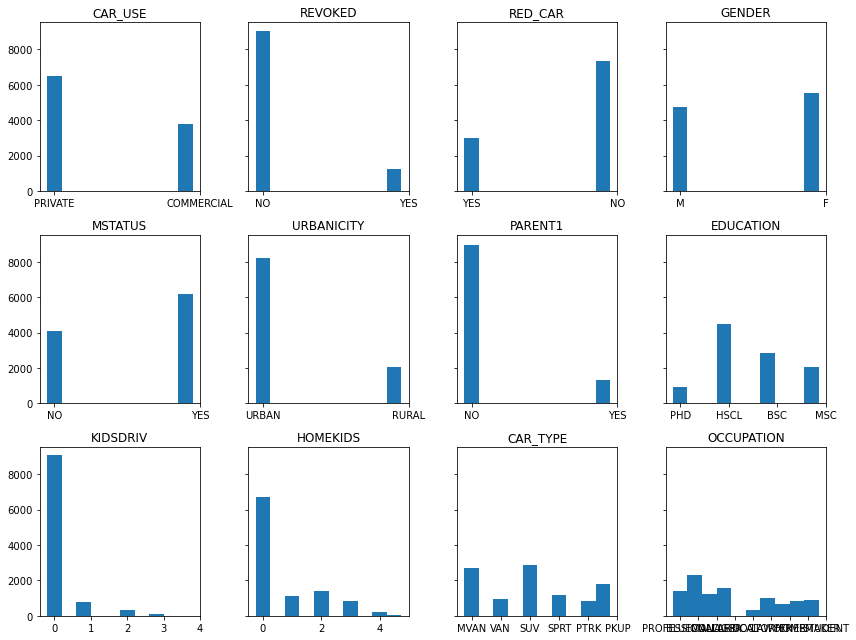

In [91]:
fig,axs = plt.subplots(3,4,figsize=(12,9),sharey=True)

for ax,feat in zip(axs.flatten(),cat_features):
    ax.hist(tdf[feat],align='left')
    ax.set_title(feat)
plt.tight_layout()

***How are claims distributed amongst the categorical features?***

As above, the bar plots again illustrate each categorical feature and value, but now also show how the proportion of claims is distributed to each categorical value. For example, Commericial CAR_USE has a relatively higher proportion of claims than Private car use.

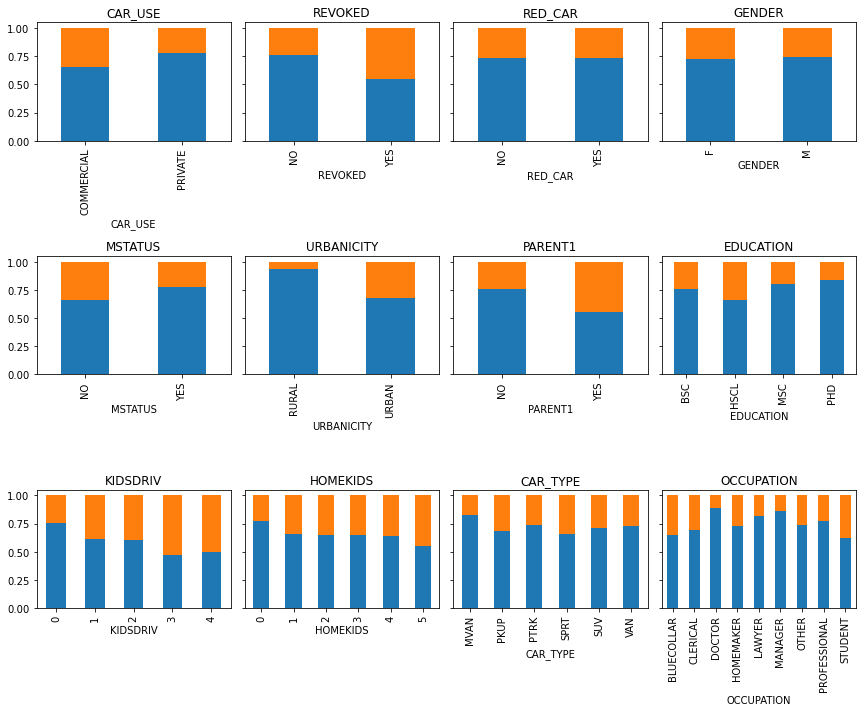

In [21]:
fig,axs = plt.subplots(3,4,figsize=(12,10),sharey=True)

for ax,feat in zip(axs.flatten(),cat_features):
    ((pd.crosstab(tdf['CLAIM_FLAG'],tdf[feat])) / (pd.crosstab(tdf['CLAIM_FLAG'],tdf[feat]).sum())).T.plot.bar(stacked=True,ax=ax,legend=False,title=None)
    ax.set_title(feat)
plt.tight_layout()

## 3.3 Clustering

Recall that each clustering algorithm is an attempt to create natural groupings of the data. At a high-level, clustering algorithms acheive this using a measure of similarity or distance between each pair of data points, between groups and partitions of points, or between points and groups to a representative central point (i.e. centroid). So while the actual algorithm impementations to achive this vary, in essence they are based on this simple principle of distance.This is illustrated quite nicely in illustration below that shows a data set with 3 clusters, and iterative cluster partitioning a-f by updating the centroid points (Chen 2018). Here the clusters are formed by measuring the distance between each data point (solid fill) and a representative centoid point (hollow fill). 

<img src="https://www.researchgate.net/profile/Yu-Zhong-Chen/publication/324073652/figure/fig2/AS:611048927277056@1522696825062/A-schematic-illustration-of-the-K-means-algorithm-for-two-dimensional-data-clustering.png" width=650 height=650 />

Because clustering algortithms utilise this concept of distance both it is crucial to consider both:
- Distance Meaasures. The distance or "similarity" measure used.
- Feature Engineering. The nature of our data and the way the data is presented the clustering algorithm.

### Distance Measures

Below are some of the common distance measures used for clustering. Computational efficiency is important here as each data feature introduces an additional dimension.For clustering, by definition, we often have a multiple features to make sense of and therefore the efficiency of the calculation in high dimensional space is crucial. 

***[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance#Higher_dimensions)*** is the absolute numerical difference of their location in euclidean space. Distances can be 0 or take on any positive real number. It is given by the root sum-of-squares of differences between each pair (p,q) of points. And we can see that for high dimensions we simply add the distance. 

$$d_n(p,q) = \sqrt{(p_1-q_1)^2+(p_2-q_2)^2...+(p_n-q_n)^2}$$

***[Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry)*** is again the sum of the absolute numerical difference between two points in space, but using cartesian cooridantes. Whilst euclidean distance is the straight line "as the crow flies" with pythagorus theorem, Manhattan takes distance as the sum of the line vectors (p,q).

$$d_n(p,q)  = \sum_{i=1}^{n} |{(p_n-q_n)}|$$

This image illustrates examples for: a) euclidean space distance, b) Manhattan distance in cartesian cooridate space, and c) both with the green line showing a euclidean path, while the blue, red, and yellow lines take a cartesian path with Manhattan distance. This illustrates how clustering results may be influenced by distance measures applied and depending on wether the data features are real and numeric or discrete ordinal and categorical values. In addition, perhaps this also illustrates to you how and why geometry and distance are important in other domains such as shortest path problems. 
<img src="spaces.png" width=750 height=450 />

There are many distance metrics (e.g. see [these slides](http://halweb.uc3m.es/esp/Personal/personas/jmmarin/esp/MetQ/Talk6.pdf)). Minkowski distance for example, is a generalization of both the Euclidean distance and the Manhattan distance. Scipy has a covenient [pair distance](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.spatial.distance.pdist.html) ```pdist()``` function that applies many of the most common measures. 

There are also hybrid distance measures. In our case study, and topic of this article, the data contains a mixture of features with different data types and this requires such a measure.

***[Gower (1971) distance](https://www.jstor.org/stable/2528823?seq)*** is a hybrid measure that handles both continuous and categorical data. 
- If the data feature are continuous or ordinal, the Manhattan or a ranked ordinal Manhattan is applied. 
- If the data feature are categorical, then a [DICE](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient#Formula) coefficient is applied. DICE is explained [here](https://stats.stackexchange.com/a/55802/100439). However, If you are familiar with Jaccard coefficient and or binary classification (e.g. True Positives TP and False Posititves FP etc) and confusion matrices then DICE is going to be familiar as

$$DICE = \frac{2|X \cap Y|}{|X|+|Y|} = \frac{2TP}{2TP+FP+FN}$$

The Gower distance of a pair of points $G(p,q)$ then is:

$$G_n(p,q) = \frac{\sum_{i=1}^{n}W_{pqk}S_{pqk}}{\sum_{i=1}^{n}W_{pqk}}$$

where $S_{pqk}$ is either the Manhattan or DICE value for feature $k$, and $W_{pqk}$ is either 1 or 0 if $k$ feature is valid. Its the sum of feature scores divided by the sum of feature weights. 
 
Gower is implemented in [Gower Python](https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/) and in [Gower R](https://rdrr.io/cran/gower/api)

## Feature Engineering

The data data features should be standardized in order to avoid dependence on the [datatypes](https://towardsdatascience.com/data-types-in-statistics-347e152e8bee) and on the variety or choice of measurement units.

Rule of thumb, when using any algorithm that computes distance or assumes normality, scale your features! [see here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e), [here](https://stats.stackexchange.com/a/7182/100439), and [here](https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca).


***Numerical features:***
Fields Continuous variables 
 - Use ratios and percentages.
 - normalisation (i.e. normalise values to be on scale of 0-1)
 - standardisation (i.e. how many standard deviations the value is from the sample mean)
 - transformation (i.e. log transformation).


***Categorical features: unordered*** 
Unordered nomial or binary symmetric values where outcomes are of equal importance (e.g. Male or Female).
 - One-hot and dummy encoding (i.e. create binary indicator of each category).
 - If handling a feature with high cardinality >15, try to reduce dimensionality by feature engineering or apply binary or hash encoding ([see here](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02))
 
 
***Categorical features: ordered***
Ordered ordinal or binary asymmetric values, where outcomes are not of equal importance (e.g. Gold, Silver, Bronze)
 - it depends!
 - Label encoding with 0-1 normalisation if values are on equal-importance increasing scale (Bronze=1,Silver=2,Gold=3, where 1=1*1, 2=2*1, 3=3*1, Gold-Bronze = 3-1 = 2 places worse).
 - Rank values with 0-1 normalisation, again if values are on equal-importance increasing scale.
 - If there is some target variable in the dataset (e.g. event occurence, medical diagnosis, iris type) one can also assign frequencies, odd ratios or weights-of-evidence to each ordinal class.

By far ordinal data is the most challenging to handle. There are many arguments between mathmatical purists, statisticians and other data practitioners on wether to treat ordinal data as qualitatively or quantitatively ([see here](https://creativemaths.net/blog/ordinal/)). In this authors opinion, ordinal data should be treated with caution and to adopt rational feature engineering and encdoing strategies based on understanding of the data and its domain.  

*It is essential to understand, for all machine learning models, all these encodings do not work well in all situations or for every dataset. Data Scientists still need to experiment and find out which works best for their specific case. If test data has different classes, then some of these methods won’t work as features won’t be similar. There are few benchmark publications by research communities, but it’s not conclusive, which works best. My recommendation will be to try each of these with the smaller datasets and then decide where to put more focus on tuning the encoding process. You can use the below cheat-sheet as a guiding tool.*


*references:*
 - https://miro.medium.com/max/2924/1*dvvxoZTdewLFs3RyZTJreA.png
 - [Datatypes in statistics](https://towardsdatascience.com/data-types-in-statistics-347e152e8bee)
 - [Binary symmetric and assymetric variables](https://www.quora.com/What-are-binary-symmetric-and-asymmetric-attributes)
 - [datatype conversions in clustering](https://paginas.fe.up.pt/~ec/files_0506/slides/05_Clustering.pdf)
 - [categorical feature engineering](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)
 - [Normalization vs Standardization — Quantitative analysis](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)
 - [Normalization vs Standardization](https://stats.stackexchange.com/a/10291/100439)
 
***numerical features***

In [93]:
from sklearn.preprocessing import scale,RobustScaler,StandardScaler, MinMaxScaler

In [94]:
# Scale standardisation of numerical values
numerical_features = pd.DataFrame(StandardScaler().fit_transform(tdf[num_features]),index=tdf.index,columns=num_features)
numerical_features = pd.DataFrame(MinMaxScaler(feature_range=(0,1)).fit_transform(tdf[num_features]),index=tdf.index,columns=num_features)

***Categorical:Nomial values with binary symmetry***

Remember, here we are taking categorical values that are symmetric in scale only. Without getting into a debate, we could consider EDUCATION and OCCUPATIOM as either nomial (i.e. no order) or ordinal (i.e. hierachal). Here i'm going to take education as ordinal and occupation as nomial.

Observing our plots above we may also want to combine some classes where there are low frequencies or high cardinality. These are:

 - KIDSDRIV: collapse >= 2 to single category
 - HOMEKIDS: collapse >= 4 to single category

We then apply one-hot-encoding.

In [95]:
cat_features.remove('EDUCATION')
tdf['KIDSDRIV'] = tdf['KIDSDRIV'].map({0:'0',1:'1',2:'2+',3:'2+',4:'2+'})
tdf['HOMEKIDS']= tdf['HOMEKIDS'].map({0:'0',1:'1',2:'2',3:'3',4:'4+',5:'4+'})

In [96]:
nomial_features = pd.get_dummies(tdf[cat_features])

***Categorical:Ordinal values with binary asymmetry***

In [97]:
tdf['EDUCATION'] = tdf['EDUCATION'].map({'HSCL':0, 'BSC':1, 'MSC':2,'PHD':3})

In [98]:
from sklearn.preprocessing import MinMaxScaler
mx = MinMaxScaler(feature_range=(0,1))

In [99]:
ordinal_features = pd.DataFrame(mx.fit_transform(tdf[['EDUCATION']]),index=tdf.index,columns=['EDUCATION'])

***Create datasets for clustering***

<span style="color:red">
Beware! check what transformations each package applies or can handle. For example, some may require features to be prepared as above a priori whilst others may handles this for you.
</span>

Rule of thumb, when using any algorithm that computes distance or assumes normality, scale your features! [see here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e) and [here](https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca).

I will create two copies of the data:
 1. using the above OHE transformations and feature scaling (0,1).
 2. applying the above transformations but without feature scaling.

In [100]:
# transformed and scaled dataset
Xy_scaled = pd.concat([numerical_features,nomial_features,ordinal_features],axis=1)
print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

Data min:max (0.0, 1.0)


In [101]:
# original data
Xy_original = tdf.drop(labels=['CLAIM_FLAG'],axis=1)

### GOWER

Gower is normalising for us see this line:https://github.com/wwwjk366/gower/blob/master/gower/gower_dist.py#L61

In [103]:
import gower

You can use Gower to find similarity between a single entity and a list of candidates. 

This seems to pick out Urban, 40-50 year old males, who drive red minivan's, no kids, and with home values of around $160 K.

In [104]:
sd = gower.gower_topn(Xy_original.iloc[4:5,:], Xy_original.iloc[:,:], n = 10)
print(Xy_original.iloc[sd['index']].describe().loc[['mean']])
Xy_original.iloc[sd['index']]

       AGE        YOJ   INCOME  HOME_VAL  EDUCATION  TRAVTIME  BLUEBOOK  TIF  \
mean  49.0  13.847406  25948.5  161218.9        0.0      28.4   11585.0  6.0   

      OLDCLAIM  CLM_FREQ  MVR_PTS  CLM_AMT  CAR_AGE  
mean       0.0       0.0      0.5    583.3      4.6  


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,...,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,URBANICITY
4,0,51.0,0,14.000000,0.0,NO,306251.0,YES,M,0,...,7,MVAN,YES,0.0,0,NO,0,0.0,6.0,URBAN
7673,0,46.0,0,13.000000,33953.0,NO,164542.0,YES,M,0,...,4,MVAN,YES,0.0,0,NO,0,2535.0,6.0,URBAN
8699,0,41.0,0,15.000000,38601.0,NO,151038.0,YES,M,0,...,6,MVAN,YES,0.0,0,NO,0,0.0,7.0,URBAN
760,0,44.0,0,14.000000,25588.0,NO,119825.0,YES,M,0,...,5,MVAN,YES,0.0,0,NO,2,0.0,4.0,URBAN
9699,0,52.0,0,16.000000,24575.0,NO,118811.0,YES,M,0,...,3,MVAN,YES,0.0,0,NO,0,0.0,1.0,URBAN
7119,0,45.0,0,14.000000,68958.0,NO,190128.0,YES,M,0,...,3,MVAN,YES,0.0,0,NO,1,0.0,1.0,URBAN
6645,0,62.0,0,13.000000,0.0,NO,157022.0,YES,M,0,...,10,MVAN,YES,0.0,0,NO,1,3298.0,1.0,URBAN
7542,0,54.0,0,10.474062,37424.0,NO,155505.0,YES,M,0,...,10,MVAN,YES,0.0,0,NO,0,0.0,1.0,URBAN
6395,0,46.0,0,13.000000,5015.0,NO,105811.0,YES,M,0,...,1,MVAN,YES,0.0,0,NO,0,0.0,8.0,URBAN
10171,0,49.0,0,16.000000,25371.0,NO,143256.0,YES,M,0,...,11,MVAN,YES,0.0,0,NO,1,0.0,11.0,URBAN


In [105]:
sd

{'index': array([    4,  7673,  8699,   760,  9699,  7119,  6645,  7542,  6395,
        10171]),
 'values': array([0.        , 0.02368223, 0.02835135, 0.02971773, 0.03438243,
        0.03619125, 0.03822155, 0.03923047, 0.03986358, 0.04293185],
       dtype=float32)}

And to calculate a matrix of similaritities between all entities

In [ ]:
# create list of cat_feature indicator
# [(x,True) if x in cat_features else (x,False) for x in Xy_original.columns]
cat_ind = [True if x in cat_features else False for x in Xy_original.columns]

try: 
    gd = np.load(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_gower_distance.npy'))
    print('Gower distances loaded from file.')
except:
    print('Calculating Gower dsitances...1-5 minutes')
    %time gd = gower.gower_matrix(Xy_original, cat_features=cat_ind)
    np.save(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_gower_distance.npy'),gd)

In [ ]:
pd.DataFrame(gd[:5,:5])

## 4 Clustering methods for mixed datatypes

1. Hierachal (Gower distance matrix from original features):
 - [see here](https://stackoverflow.com/a/55306715/4538066) for discusion of suitable distance methods.
1. K-medoids (transformed and scaled features):
 - [distance metrics for k-medoids](https://stats.stackexchange.com/a/94178/100439)
 - [k-mediods in pyclustering package](https://pypi.org/project/pyclustering/)
    - [ISSUE](https://github.com/annoviko/pyclustering/issues/503) pyclustering package does not implement PAM as suggested on other sites.
 - K-medoids is poor performing on large datasets.
 - [k-mediods python implmentation in scikit-learn-extra](https://scikit-learn-extra.readthedocs.io/en/latest/install.html)
 - [C++ build tools may be required on windows](https://www.scivision.dev/python-windows-visual-c-14-required/)
1. CLARANS (transformed and scaled features)
 - [Raymond, T., et al. 2002. CLARANS](http://www.cs.ecu.edu/dingq/CSCI6905/readings/CLARANS.pdf)
 - [clarans in python](https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4)
1. PAM partition-around-medoids (transformed and scaled features)
 - [PAM  is a variation of K-medoids](https://stats.stackexchange.com/a/141208/100439)
 - [Self defined PAM k-medoids in python](https://towardsdatascience.com/k-medoids-clustering-on-iris-data-set-1931bf781e05)
1. K-means (transformed and scaled features)

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_samples, silhouette_score

## 4.1 Hierachal (Gower distance matrix from original features)

[scipy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) is used to generate:
 - $Z$, an ($n-1$) by 4 matrix . 
 - At the -th iteration, clusters with indices $Z[i, 0]$ and $Z[i, 1]$ are combined to form cluster.
 - A cluster with an index less than corresponds to one of the original observations. 
 - The distance between clusters $Z[i, 0]$ and $Z[i, 1]$ is given by $Z[i, 2]$. 
 - The fourth value $Z[i, 3]$ represents the number of original observations in the newly formed cluster.

In [ ]:
# output matrix has format [idx1, idx2, dist, sample_count]
try: 
    Z = np.load(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_linkage-complete.npy'))
    print('Z linkages loaded from file.')
except:
    print('Calculating Gower dsitances...1-5 minutes')
    %time Z = linkage(gd,method='complete')
    np.save(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_linkage-complete.npy'),Z)
    
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])

Visualise using a [scipy.dendogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram)

[*note*](https://stackoverflow.com/questions/9838861/scipy-linkage-format) it is not practical to infer the cluster or each observation using linkage and dendogram ouput.

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
dn = dendrogram(Z, truncate_mode='level',p=6,show_leaf_counts=True,ax=axs);
print(f"Leaves = {len(dn['leaves'])}")

Now to find the optimal number of clusters we apply:
1. [fcluster](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster) to form flat clusters from the hierarchical clustering defined by the linkage matrix ($Zd$).
1. [Silhouette scoring](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) to determine an appropriate number of clusters ($k$) or level in the dendogram. The Silhouette Coefficient ($S$) is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample where:
$$S = (b - a) / max(a, b)$$
 - ($S_1$) is computed using the "precomputed" Gower distances.
 - ($S_2$) is computed using predefined distance measures from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#) or [scipy](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html), in this instance "correlation". BUT, this only works on our transformed and scaled features created earlier.
 

In [ ]:
# find k clusters
results = dict()

k_cand = [2,3,4,5,7,9,]
k_cand.extend(list(np.arange(10,55,5)))

for k in k_cand:
    cluster_array = fcluster(Z, k, criterion='maxclust')
    score1 = silhouette_score(gd, cluster_array, metric='precomputed')
    score2 = silhouette_score(Xy_scaled, cluster_array,metric='correlation')
    results[k] = {'k':cluster_array,'s1':score1,'s2':score2}
    
plt.plot([i for i in results.keys()],[i['s1'] for i in results.values()],label='gower')
plt.plot([i for i in results.keys()],[i['s2'] for i in results.values()],label='correlation')
plt.legend()
plt.xticks(k_cand);

Visualising the silhouette scores indicates that there are increases "spikes" in scores at 7 and 40 clusters.
Lets investigate these two sets.

In [ ]:
# assign 7 and 40
tdf['k-medoids-7'] =results[7]['k']
tdf['k-medoids-40'] =results[40]['k']

In [ ]:
fig,axs = plt.subplots(6,2,figsize=(10,15),sharex=True)

for ax,feat in zip(axs.flatten(),num_features):
    pd.plotting.boxplot(tdf,column=[feat],by='k-medoids-7',ax=ax)
    ax.set_xlabel('')  
plt.tight_layout()

In [ ]:
fig,axs = plt.subplots(11,1,figsize=(10,40),sharex=True)

for ax,feat in zip(axs.flatten(),num_features):
    pd.plotting.boxplot(tdf,column=[feat],by='k-medoids-40',ax=ax)
    ax.set_xlabel('')

plt.tight_layout()

In [ ]:
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

K-medoids can be caluclated using many distance metrics. Here the *Minkowski distance* or "cityblock" is used as this provides a suitable measure where there are both categorical and numerical features [see here](https://www2.cs.duke.edu/courses/spring18/compsci216/lectures/07-clustering.pdf).



In [ ]:
try: 
    Xy_scaled_minkowski = np.load(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_Xy_scaled_minkowski.npy'))
    print('Minkowski distances loaded from file.')
except:
    print('Calculating Minkowski dsitances...1-5 minutes')
    %time Xy_scaled_minkowski = squareform(pdist(Xy_scaled, 'minkowski'))
    np.save(os.path.join(DATA_PATH,'car-insurance-claim-data/car_insurance_claim_Xy_scaled_minkowski.npy'),Xy_scaled_minkowski)

I'm going to use the pyclustering implmentation in order to have comparison's to the similar, yet more memory efficient, PAM and CLARANS medoid methods.

<span style="color:red">
Beware! pyclustering return clusters in an $n$ length list of lists, where $n=k$ and $list$[$n$][$i$] is the index postion from the input distance matrix. Here i use a dataframe to convert the pyclustering output to the form expected by scikit-learn silhouette score.
    
- [see this issue](https://github.com/annoviko/pyclustering/issues/593)  
</span>

In [ ]:
# find k clusters
results_kmedoids = dict()

k_cand = [3,7,15,30,45,60]
#k_cand.extend(list(np.arange(10,55,5)))

for k in k_cand:
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0,1000,size=k)
    kmedoids_instance = kmedoids(Xy_scaled_minkowski,initial_medoids, data_type='distance_matrix')    

    # run cluster analysis and obtain results
    %time kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    score1 = silhouette_score(Xy_scaled_minkowski, cluster_array, metric='precomputed')
    score2 = silhouette_score(Xy_scaled, cluster_array,metric='correlation')
    
    # store
    results_kmedoids[k] = {'k':cluster_array,'s1':score1,'s2':score2}
    
plt.plot([i for i in results_kmedoids.keys()],[i['s1'] for i in results_kmedoids.values()],label='Minkowski')
plt.plot([i for i in results_kmedoids.keys()],[i['s2'] for i in results_kmedoids.values()],label='correlation')
plt.legend()
plt.xticks(k_cand);

## 4.3 CLARANS (transformed and scaled features)
### *Clustering Large Applications based on RANdomized Search*
 - [clarans in python](https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4)

In [ ]:
from pyclustering.cluster.clarans import clarans
from pyclustering.utils import euclidean_distance_square

In [ ]:
Xy_scaled_list = Xy_scaled.to_numpy().tolist()
len(Xy_scaled_list)

# sample euclid
# [euclidean_distance_square(Xy_scaled_list[0],Xy_scaled_list[i]) for i in range(4)]

"""
data: Input data that is presented as list of points (objects), each point should be represented by list or tuple.
number_clusters: amount of clusters that should be allocated.
numlocal: the number of local minima obtained (amount of iterations for solving the problem).
maxneighbor: the maximum number of neighbors examined.     
The higher the value of maxneighbor, the closer is CLARANS to K-Medoids, and the longer is each search of a local minima.
"""

clarans_instance = clarans(data=Xy_scaled_list[:50], number_clusters=3, numlocal=1, maxneighbor=2)
%time clarans_instance.process()
clusters = clarans_instance.get_clusters()

#returns the clusters & medoids
clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

In [ ]:
Xy_scaled.shape

**OK! Something strange is happening here.**

Our supposedly efficient CLARANS is grinding through on our 10302*49 dimension data, taking some 5 minutes to process just 1000 rows. I think that we are hitting the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), as the CLARANS implementaiton in pyclustering uses a euclidean distance metric. Euclidean distance breaks down in high dimensional space (see [here](https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6) and [here](https://en.wikipedia.org/wiki/Clustering_high-dimensional_data). There are several things we could try here:

 - One option would be to re-write the CLARANS method using a distance metric that is robust to high dimensionality, such as the Manhattan or Minkowski distance.
 - Apply an alternative clustering approach that is less affected by high dimensionality such as [spectral](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering) or a Hierarchal approach as above or [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html).
 - Anoter would be to reduce dimensionality using [*tSNE*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see guides [here](https://www.datacamp.com/community/tutorials/introduction-t-sne) and [here](https://towardsdatascience.com/entity-embedding-using-t-sne-973cb5c730d7)).

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne_model = TSNE(n_components=3, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(Xy_scaled)

In [ ]:
# find k clusters
results_tsne_clarans = dict()

k_cand = [3,7,15,30,45,60]
#k_cand.extend(list(np.arange(10,55,5)))

"""
data: Input data that is presented as list of points (objects), each point should be represented by list or tuple.
number_clusters: amount of clusters that should be allocated.
numlocal: the number of local minima obtained (amount of iterations for solving the problem).
maxneighbor: the maximum number of neighbors examined.     
The higher the value of maxneighbor, the closer is CLARANS to K-Medoids, and the longer is each search of a local minima.
"""

for k in k_cand:
    clarans_instance = clarans(data=tsne.tolist(), number_clusters=k, numlocal=1, maxneighbor=2)
    %time clarans_instance.process()
    #returns the clusters & medoids
    clusters = clarans_instance.get_clusters()
    medoids = clarans_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    score1 = 0 # silhouette_score(Xy_scaled_minkowski, cluster_array, metric='precomputed')
    score2 = silhouette_score(Xy_scaled, cluster_array,metric='correlation')
    
    # store
    results_tsne_clarans[k] = {'k':cluster_array,'s1':score1,'s2':score2}
    
plt.plot([i for i in results_tsne_clarans.keys()],[i['s1'] for i in results_tsne_clarans.values()],label='Minkowski')
plt.plot([i for i in results_tsne_clarans.keys()],[i['s2'] for i in results_tsne_clarans.values()],label='correlation')
plt.legend()
plt.xticks(k_cand);

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(20, 20),sharex=True,sharey=True)

for j,ax in zip(results_tsne_clarans.keys(),axs.flatten()):
    plotting = pd.DataFrame([(e,i) for e,i in enumerate(results_tsne_clarans[j]['k'])],columns=['id','k']).sort_values(by='id').sort_values(by='id')
    plotting['x'] = tsne[:,0]
    plotting['y'] = tsne[:,1]
    groups = plotting.groupby('k')
    
    for name, group in groups:
        ax.plot(group['x'], group['y'], marker='o', linestyle='', label=name)
        #ax.legend()
        ax.set_title(f'CLARANS-$tSNE$ ($k$={j})')
plt.show()   

## 4.4 PAM partition-around-medoids (transformed and scaled features)
 - [PAM  is a variation of K-medoids](https://stats.stackexchange.com/a/141208/100439)
 - [Self defined PAM k-medoids in python](https://towardsdatascience.com/k-medoids-clustering-on-iris-data-set-1931bf781e05)

## To Do list

### Inspect value's between sets of clusters and intra-clusters:
 - Descriptive statistics
 - Categorical features: with chi squared
 - Numerical features: t-test, non-paramteric tests, correlaiton
 

- [Notes on data mining](https://gist.github.com/AKST/d27b9006bb0f9670e370)
- http://eric.univ-lyon2.fr/~ricco/cours/slides/en/classif_interpretation.pdf
- https://online.stat.psu.edu/stat414/node/116/
- https://www2.cs.duke.edu/courses/spring18/compsci216/lectures/07-clustering.pdf

# *References*


- https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/
- https://pypi.org/project/gower/
- https://medium.com/analytics-vidhya/gowers-distance-899f9c4bd553
- https://www.researchgate.net/publication/324073652_Sparse_dynamical_Boltzmann_machine_for_reconstructing_complex_networks_with_binary_dynamics
- https://towardsdatascience.com/clustering-on-mixed-type-data-8bbd0a2569c3
- https://medium.com/@rumman1988/clustering-categorical-and-numerical-datatype-using-gower-distance-ab89b3aa90d9
- https://www2.cs.duke.edu/courses/spring18/compsci216/lectures/07-clustering.pdf
- https://towardsdatascience.com/hierarchical-clustering-on-categorical-data-in-r-a27e578f2995
- https://www.researchgate.net/post/What_is_the_best_way_for_cluster_analysis_when_you_have_mixed_type_of_data_categorical_and_scale
- https://www.google.com/search?client=firefox-b-d&q=python+gower+distance
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
- https://discuss.analyticsvidhya.com/t/clustering-technique-for-mixed-numeric-and-categorical-variables/6753
- https://stackoverflow.com/questions/24196897/r-distance-matrix-and-clustering-for-mixed-and-large-dataset
- https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/
- https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
- https://rpubs.com/data_feelings/msda_data621_hw4
- https://pypi.org/project/gower/
- https://scikit-learn-extra.readthedocs.io/en/latest/generated/sklearn_extra.cluster.KMedoids.html
- https://towardsdatascience.com/k-medoids-clustering-on-iris-data-set-1931bf781e05
- https://www.rdocumentation.org/packages/cluster/versions/2.1.0/topics/pam
- https://github.com/annoviko/pyclustering/issues/499
- https://stats.stackexchange.com/questions/2717/clustering-with-a-distance-matrix
- https://www.kaggle.com/fabiendaniel/customer-segmentation
- https://dkopczyk.quantee.co.uk/claim-prediction/ (http://web.archive.org/web/20190429040211/https://dkopczyk.quantee.co.uk/claim-prediction/)
- https://www.casact.org/pubs/dpp/dpp08/08dpp170.pdf
- https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4
- https://www.uio.no/studier/emner/matnat/math/nedlagte-emner/STK2510/v08/undervisningsmateriale/ch8b.pdf
- https://github.com/annoviko/pyclustering/issues/499
- https://stackoverflow.com/questions/3081066/what-techniques-exists-in-r-to-visualize-a-distance-matrix
- https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68
- https://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data
- http://www.cs.ust.hk/~qyang/Teaching/537/Papers/huang98extensions.pdf
- https://www.researchgate.net/post/What_is_the_best_way_for_cluster_analysis_when_you_have_mixed_type_of_data_categorical_and_scale
- https://towardsdatascience.com/hierarchical-clustering-on-categorical-data-in-r-a27e578f2995
- https://gist.github.com/AKST/d27b9006bb0f9670e370
